In [87]:
import torch
import torch.nn.functional as F

In [2]:
with open('./names.txt','r',encoding='utf-8') as f:
    words = f.read().splitlines()

In [4]:
len(words)

32033

In [7]:
chars = []
chars.append('.')
chars = chars+sorted(list(set(''.join(words))))

In [8]:
# 定义两个函数用以转换字符到数字和数字到字符
stoi = lambda x: chars.index(x)
itos = lambda x: chars[x]

In [102]:
block_size = 3
X,Y = [],[]
for w in words[:]:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi(ch)
        X.append(context)
        Y.append(ix)
        # print(''.join(itos(xi) for xi in context), '--->', itos(ix))
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [103]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [21]:
# build an embedding table
C = torch.randn((27,2))

In [23]:
C[1]

tensor([ 1.1006, -0.4975])

In [40]:
# 将X中的整数值转换成C矩阵中的2维向量，这个过程称之为嵌入（embedding）,C矩阵也被称为是lookup table
# X中整数的范围是[0,26]，一共有27个不重复的元素，C矩阵的大小是[27,2]，对应每一个整数，C矩阵中都有一个2维向量与之对应
# 对应X中的每一个整数元素，都在C表中检索了对应的2维向量
# embedding的目的就是将整数空间嵌入到多维的向量空间
C[X].shape

torch.Size([32, 3, 2])

In [34]:
# 验证嵌入矩阵的运算正确
X[0]

tensor([0, 0, 0])

In [35]:
C[X][0][0]

tensor([-1.7255, -1.0825])

In [39]:
# C[X][0][0]==C[0]
C[0]
C[X][0][0]==C[0]

tensor([True, True])

In [42]:
# make input embedded
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [44]:
emb = emb.view(emb.shape[0],6)
emb.shape

torch.Size([32, 6])

In [45]:
w1 = torch.randn((6,100))
b1 = torch.randn(100)

In [48]:
h = emb @ w1 +b1

In [49]:
h.shape

torch.Size([32, 100])

In [50]:
h = F.tanh(h)

In [52]:
w2 = torch.randn((100,27))
b2 = torch.randn(27)

In [53]:
logits = h @ w2 + b2

In [60]:
counts = logits.exp()

In [65]:
probs = counts/counts.sum(1,keepdim=True)

In [74]:
loss = -probs[torch.arange(32), Y].log().mean()

In [75]:
loss

tensor(16.8497)

### Make it respectable

In [147]:
# dataset
X.shape,Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [161]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
w1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
w2 = torch.randn((100,27),generator=g)
b2 = torch.randn(27,generator=g)

In [162]:
parameters = [C,w1,b1,w2,b2]

In [150]:
sum(n.nelement() for n in parameters)

3481

In [91]:
# emb = C[X]
# h = torch.tanh(emb.view(X.shape[0],6) @ w1 +b1)
# logits = h @ w2 + b2
# # counts = logits.exp()
# # probs = counts / counts.sum(1,keepdim=True)
# # loss = probs[torch.arange(X.shape[0]),Y].log().mean()
# # 这里等价于pytorch中的cross entropy，因为计算优化的原因，应该始终使用torch提供的此类函数
# loss = F.cross_entropy(logits,Y)
# loss

tensor(17.7697)

In [163]:
for p in parameters:
    p.requires_grad = True

In [128]:
for _ in range(1000):
    # build mini batch
    ix = torch.randint(0,X.shape[0],(32,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(emb.shape[0],6) @ w1 +b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data +=-0.1*p.grad
print(f'loss = {loss}')


loss = 2.624229907989502


In [129]:
# 评估所有数据集的loss
emb = C[X]
h = torch.tanh(emb.view(emb.shape[0],6) @ w1 +b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits,Y)
print(f'loss = {loss}')

loss = 2.530228614807129


## 如何确定一个良好的初始学习率，注意这里只是确定初始学习率

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lri = 10**lre
lossi = []
for i in range(1000):
    # build mini batch
    ix = torch.randint(0,X.shape[0],(32,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(emb.shape[0],6) @ w1 +b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,Y[ix])
    lossi.append(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lri[i]
    for p in parameters:
        p.data +=-lr*p.grad

loss = 8.21008014678955


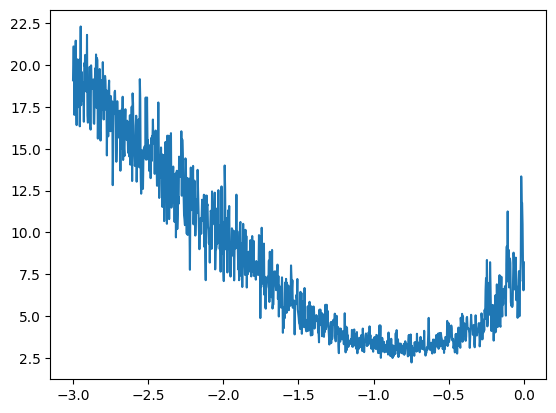

In [153]:
from matplotlib.pyplot import plot
plot(lre,lossi)

## 可以看到当lre=-1.0时，整个loss随lre的曲线是到了一个谷底的位置，并且相对平缓，说明此时的学习率是合适的

### 因此学习率的取值可以是10**-1.0 

## 数据集拆分
### train, dev ,test
### 80% 10% 10%

其中80%的数据用来训练神经网络的参数，dev占据的10%的数据用来测试不同的超参数（嵌入维度，mini batch size，隐藏层数，隐藏层神经元，学习率等）的表现，test的数据用来确保网络没有进入过拟合的状态

In [160]:
# build the dataset

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi(ch)
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [172]:
lossi = []
stepi = []
for i in range(30000):
    # build mini batch
    ix = torch.randint(0,Xtr.shape[0],(32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0],6) @ w1 +b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,Ytr[ix])
    lossi.append(loss.item())
    stepi.append(i)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr=0.1
    for p in parameters:
        p.data +=-lr*p.grad
print(f'train loss = {loss}')

train loss = 2.421971082687378


In [173]:
# 评估测试数据集的loss
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0],6) @ w1 +b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits,Ydev)
print(f'test loss = {loss}')

test loss = 2.3348541259765625


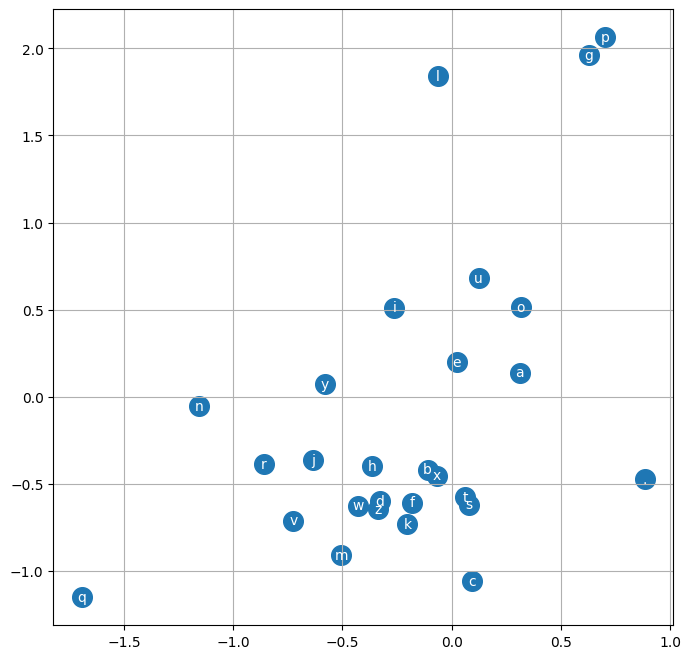

In [177]:
import matplotlib.pyplot as plt # for making figures
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos(i), ha="center", va="center", color='white')
plt.grid('minor')

# Those clusterred close together are similar, and those far apart are dissimilar.
# Those furthest away are treated as exceptions.

## 扩大网络规模

In [184]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator=g)
w1 = torch.randn((30,200),generator=g)
b1 = torch.randn(200,generator=g)
w2 = torch.randn((200,80),generator=g)
b2 = torch.randn(80,generator=g)
w3 = torch.randn((80,27),generator=g)
b3 = torch.randn(27,generator=g)
parameters = [C,w1,b1,w2,b2,w3,b3]
for p in parameters:
    p.requires_grad = True

In [185]:
sum(n.nelement() for n in parameters)

24737

In [191]:
for i in range(20000):
    # build mini batch
    ix = torch.randint(0,X.shape[0],(32,))
    # forward pass
    emb = C[X[ix]]
    h1 = torch.tanh(emb.view(emb.shape[0],30) @ w1 +b1)
    h2 =  torch.tanh(h1 @ w2 + b2)
    logits = h2 @ w3 + b3
    loss = F.cross_entropy(logits,Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i <10000 else 0.01
    for p in parameters:
        p.data +=-lr*p.grad
print(f'loss = {loss}')

loss = 2.0550286769866943


In [192]:
# 评估测试数据集的loss
emb = C[Xdev]
h1 = torch.tanh(emb.view(emb.shape[0],30) @ w1 +b1)
h2 =  torch.tanh(h1 @ w2 + b2)
logits = h2 @ w3 + b3
loss = F.cross_entropy(logits,Ydev)
print(f'test loss = {loss}')

test loss = 2.230250835418701
